In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import callbacks

2023-03-13 12:50:40.178113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 12:50:41.702102: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-13 12:50:41.702128: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-13 12:50:52.148499: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [3]:
waste_types = pathlib.Path('/home/loupy/code/Loupy2023/get_it_right/raw_data/waste_types')
garb_cardboard = list(waste_types.glob('cardboard/*'))
garb_glass = list(waste_types.glob('glass/*'))
garb_paper = list(waste_types.glob('paper/*'))
garb_metal = list(waste_types.glob('metal/*'))
garb_plastic = list(waste_types.glob('plastic/*'))
garb_trash = list(waste_types.glob('trash/*'))
img = Image.open(str(garb_cardboard[100]))
img_height, img_width =  img.size
batch_size = 32

In [4]:
img_height

512

In [5]:
img_width
img.size

(512, 384)

In [6]:
data = image_dataset_from_directory(waste_types)
class_names = data.class_names
print(class_names)

Found 4837 files belonging to 5 classes.
['cardboard', 'glass', 'metal', 'paper', 'plastic']


2023-03-13 12:51:06.852030: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-13 12:51:06.852934: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-13 12:51:06.854512: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-603AUFB): /proc/driver/nvidia/version does not exist
2023-03-13 12:51:06.859401: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Split


In [7]:
import pathlib
dataset_url = pathlib.Path('/home/loupy/code/Loupy2023/get_it_right/raw_data/waste_types')

In [8]:
batch_size = 16
img_height = 512
img_width = 384

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_url,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode = "categorical")

Found 4837 files belonging to 5 classes.
Using 3870 files for training.


In [10]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_url,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode = "categorical")

Found 4837 files belonging to 5 classes.
Using 967 files for validation.


In [11]:
class_names = train_ds.class_names
class_names

['cardboard', 'glass', 'metal', 'paper', 'plastic']

In [12]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

2023-03-13 12:52:48.763885: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 37748736 exceeds 10% of free system memory.
2023-03-13 12:52:49.198498: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 37748736 exceeds 10% of free system memory.


(16, 512, 384, 3)
(16, 5)


In [13]:
num_classes = len(class_names) 
num_classes

5

# Building model

In [15]:
# define the pre-processing layers
from tensorflow.keras import layers

# Define the model architecture
def initialize_model():
        
    model = Sequential([
      layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.1),
      #layers.RandomCrop(input_shape[0], input_shape[1]),
      layers.Conv2D(5, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(10, activation='relu'),
      layers.Dense(num_classes, activation='softmax')
    ])  
    
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
    return model


In [16]:
model = initialize_model()

2023-03-13 12:54:12.700169: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 7864320 exceeds 10% of free system memory.
2023-03-13 12:54:12.707942: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 7864320 exceeds 10% of free system memory.
2023-03-13 12:54:12.715328: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 7864320 exceeds 10% of free system memory.


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 512, 384, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 512, 384, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 512, 384, 3)      0         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (None, 512, 384, 5)       140       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 192, 5)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 192, 16)      7

In [18]:
#Train the model
es = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(
  train_ds,
  validation_data=test_ds,
  batch_size=batch_size,
  epochs=50,
  callbacks=[es],
  verbose=1
)

Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "/home/loupy/.pyenv/versions/3.10.6/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/loupy/.pyenv/versions/3.10.6/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/loupy/.pyenv/versions/3.10.6/envs/get_it_right/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/loupy/.pyenv/versions/3.10.6/envs/get_it_right/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/loupy/.pyenv/versions/3.10.6/envs/get_it_right/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/home/loupy/.pyenv/versions/3.10.6/envs/get_it_right/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/loupy/.pyenv/versions/3.10.6/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/home/loupy/.pyenv/versions/3.10.6/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/home/loupy/.pyenv/versions/3.10.6/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/loupy/.pyenv/versions/3.10.6/envs/get_it_right/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/home/loupy/.pyenv/versions/3.10.6/envs/get_it_right/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/home/loupy/.pyenv/versions/3.10.6/envs/get_it_right/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/home/loupy/.pyenv/versions/3.10.6/envs/get_it_right/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/loupy/.pyenv/versions/3.10.6/envs/get_it_right/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/loupy/.pyenv/versions/3.10.6/envs/get_it_right/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/loupy/.pyenv/versions/3.10.6/envs/get_it_right/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/home/loupy/.pyenv/versions/3.10.6/envs/get_it_right/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/home/loupy/.pyenv/versions/3.10.6/envs/get_it_right/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/loupy/.pyenv/versions/3.10.6/envs/get_it_right/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/loupy/.pyenv/versions/3.10.6/envs/get_it_right/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/loupy/.pyenv/versions/3.10.6/envs/get_it_right/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_6002/3475726534.py", line 3, in <module>
      history = model.fit(
    File "/home/loupy/.pyenv/versions/3.10.6/envs/get_it_right/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/loupy/.pyenv/versions/3.10.6/envs/get_it_right/lib/python3.10/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/loupy/.pyenv/versions/3.10.6/envs/get_it_right/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/loupy/.pyenv/versions/3.10.6/envs/get_it_right/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/loupy/.pyenv/versions/3.10.6/envs/get_it_right/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/loupy/.pyenv/versions/3.10.6/envs/get_it_right/lib/python3.10/site-packages/keras/engine/training.py", line 1024, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/loupy/.pyenv/versions/3.10.6/envs/get_it_right/lib/python3.10/site-packages/keras/engine/training.py", line 1082, in compute_loss
      return self.compiled_loss(
    File "/home/loupy/.pyenv/versions/3.10.6/envs/get_it_right/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/loupy/.pyenv/versions/3.10.6/envs/get_it_right/lib/python3.10/site-packages/keras/losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "/home/loupy/.pyenv/versions/3.10.6/envs/get_it_right/lib/python3.10/site-packages/keras/losses.py", line 284, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/loupy/.pyenv/versions/3.10.6/envs/get_it_right/lib/python3.10/site-packages/keras/losses.py", line 2098, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "/home/loupy/.pyenv/versions/3.10.6/envs/get_it_right/lib/python3.10/site-packages/keras/backend.py", line 5633, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [16,5] and labels shape [80]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_4449]

In [18]:
evaluate = model.evaluate(test_ds, verbose=1)

61/61 [==============================] - 19s 300ms/step - loss: 1.1105 - categorical_accuracy: 0.1717 - categorical_hinge: 0.2948 - hinge: 0.6739


In [20]:
dataset_url_test = pathlib.Path('/home/loupy/code/Loupy2023/get_it_right/raw_data')
garb_test = list(dataset_url_test.glob('test/*'))
img = Image.open(str(garb_test[5]))

#imag_new = model.predict(img)
img_array = tf.expand_dims(img, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 1s 523ms/step
This image most likely belongs to paper with a 26.80 percent confidence.


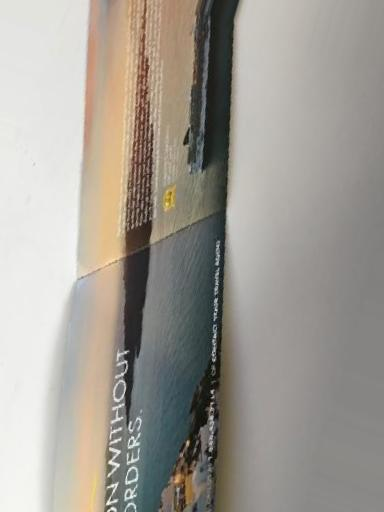

In [21]:
img

In [22]:
model.save("detection_model_by_fbl")

INFO:tensorflow:Assets written to: detection_model_by_fbl/assets


INFO:tensorflow:Assets written to: detection_model_by_fbl/assets
